In [25]:
import os
import cv2
import torch
import numpy as np
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
from samples.CLS2IDX import CLS2IDX
import torchvision.transforms as transforms

from trans_exp.utils.load_weights import load_weights
from trans_exp.baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from trans_exp.baselines.ViT.ViT_explanation_generator import LRP
from trans_exp.utils.plot_utils import visualize, show_cam_on_image

In [26]:
def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

# Custom tests

### get trained weights in the correct format

In [27]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
sample_path = flightmare_path / "flightpy/results/students/teacher_PPO_5/12-26-14-24-47/data/000/000000.npz"
weight_path = flightmare_path / "flightpy/results/students/teacher_PPO_5/vit_01-03-13-54-10/model/vit_ep20_data_data_584640.pth"

current_path = Path(os.getcwd())

In [28]:
# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()

# load custom trained weights
# NOTE: no weights for head.weight and head.bias in the custom weights
weights = load_weights(weight_path, "vit", "cuda")
model.load_state_dict(weights, strict=False)
model.eval()

attribution_generator = LRP(model)

In [29]:
# from dataset "12-26-14-24-47"
normalize = transforms.Normalize(mean=[0.48236614, 0.5381361, 0.5536909], 
                                    std=[0.27358302, 0.2505713, 0.255988])
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
normalize,
])

Top 5 classes:
	884 : vault            		value = 8.842	 prob = 62.1%
	538 : dome             		value = 7.105	 prob = 10.9%
	718 : pier             		value = 4.935	 prob = 1.2%
	821 : steel arch bridge		value = 4.887	 prob = 1.2%
	727 : planetarium      		value = 4.585	 prob = 0.9%


(-0.5, 223.5, 223.5, -0.5)

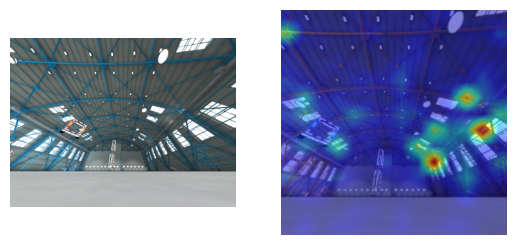

In [30]:

image = np.load(sample_path)
image = Image.fromarray(image["rgb"].squeeze())

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image);
axs[0].axis('off');

image = transform(image).unsqueeze(0)

output = model(image.cuda())
print_top_classes(output)

image_trans_gen, trans_gen = visualize(attribution_generator, image)
heatmap = show_cam_on_image(image_trans_gen[0], trans_gen[0])

axs[1].imshow(heatmap)
axs[1].axis('off')

# Examples

## Cat-Dog

Top 5 classes:
	282 : tiger cat       		value = 10.559	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.059	 prob = 15.3%
	285 : Egyptian cat    		value = 8.414	 prob = 8.0%
	243 : bull mastiff    		value = 7.425	 prob = 3.0%
	811 : space heater    		value = 5.152	 prob = 0.3%


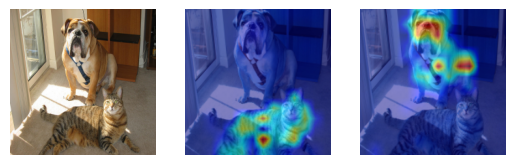

In [31]:
image = Image.open(current_path.parent / 'samples/catdog.png')
dog_cat_image = transform(image).unsqueeze(0)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_cat_image.cuda())
print_top_classes(output)

# cat - the predicted class
image_trans_gen, trans_gen = visualize(attribution_generator, dog_cat_image)
cat = show_cam_on_image(image_trans_gen[0], trans_gen[0])

# dog generate visualization for class 243: 'bull mastiff'
image_trans_gen, trans_gen = visualize(attribution_generator, dog_cat_image, class_index=243)
dog = show_cam_on_image(image_trans_gen[0], trans_gen[0])


axs[1].imshow(cat);
axs[1].axis('off');
axs[2].imshow(dog);
axs[2].axis('off');

## Tusker-Zebra

Top 5 classes:
	101 : tusker                              		value = 11.216	 prob = 37.9%
	340 : zebra                               		value = 10.973	 prob = 29.7%
	386 : African elephant, Loxodonta africana		value = 10.747	 prob = 23.7%
	385 : Indian elephant, Elephas maximus    		value = 9.547	 prob = 7.2%
	343 : warthog                             		value = 5.566	 prob = 0.1%


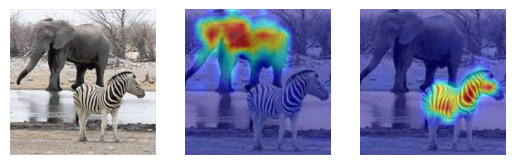

In [32]:
image = Image.open(current_path.parent / 'samples/el2.png')
tusker_zebra_image = transform(image).unsqueeze(0)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(tusker_zebra_image.cuda())
print_top_classes(output)

# tusker - the predicted class
image_trans_gen, trans_gen = visualize(attribution_generator, tusker_zebra_image, class_index=101)
tusker = show_cam_on_image(image_trans_gen[0], trans_gen[0])

# zebra 
# generate visualization for class 340: 'zebra'
image_trans_gen, trans_gen = visualize(attribution_generator, tusker_zebra_image, class_index=340)
zebra = show_cam_on_image(image_trans_gen[0], trans_gen[0])

axs[1].imshow(tusker);
axs[1].axis('off');
axs[2].imshow(zebra);
axs[2].axis('off');

Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%


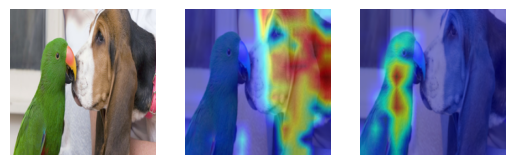

: 

In [33]:
image = Image.open(current_path.parent / 'samples/dogbird.png')
dog_bird_image = transform(image).unsqueeze(0)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(image);
axs[0].axis('off');

output = model(dog_bird_image.cuda())
print_top_classes(output)

# basset - the predicted class
image_trans_gen, trans_gen = visualize(attribution_generator, dog_bird_image, class_index=161)
basset = show_cam_on_image(image_trans_gen[0], trans_gen[0])

# generate visualization for class 87: 'African grey, African gray, Psittacus erithacus (grey parrot)'
image_trans_gen, trans_gen = visualize(attribution_generator, dog_bird_image, class_index=87)
parrot = show_cam_on_image(image_trans_gen[0], trans_gen[0])

axs[1].imshow(basset);
axs[1].axis('off');
axs[2].imshow(parrot);
axs[2].axis('off');